# Задача семантической сегментации

В данной лекции мы с вами разберем пример семантической сегментации с использованием фреймворка TensorFlow. Данный ноутбук распространяется вместе с набором данных WoodSegmentation и изображением model.png, которые должны находиться в той же папке, что и ноутбук.

Как обычно, сначала убедимся, что у нас установлены все необходимые пакеты и импортируем их.

In [ ]:
!pip install numpy tensorflow matplotlib seaborn pandas

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Используемый набор данных представляет собой измененный набор данных из следующего источника: https://www.kaggle.com/mrhexin/woodmicroscopicpores  

Данные также преобразованы в формат TensorFlow Dataset для удобства работы. Импортируем набор данных и проверим, сколько изображений нам доступно.

In [ ]:
dataset = tf.data.experimental.load('WoodSegmentationSmall.tfds', element_spec=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(224, 224), dtype=tf.float64, name=None)))
len(dataset)

24

Разделим представленный набор данных на тренировочный и тестовый наборы. В качестве тренировочного возьмем первые 20 изображений, а следующие 4 — в качестве тестового набора. Также укажем, что данные при обучении необходимо подавать батчами.

In [ ]:
train_dataset = dataset.take(20).batch(2)
test_dataset = dataset.skip(20).take(4).batch(1)

Давайте посмотрим на представленные изображения. Изображения представляют собой увеличенные под микроскопом фотографии древесины, где на масках размечены поры в древесине. Задачей сети станет сегментация пор на изображениях.  

Стоит отметить, что набор данных является тренировочным и может быть изучен другими методами, в том числе так называемой бинаризацией изображения. Однако в нашем случае на данном примере удобно посмотреть на пример решения похожих задач при помощи нейросетей.

Выведем изображения и маски для наглядной визуализации.

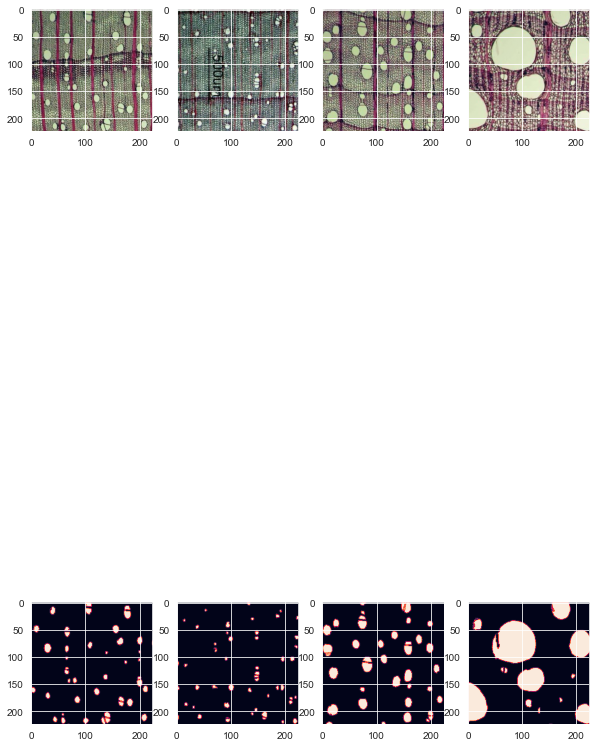

In [ ]:
imgs, masks = [], []
for pair in test_dataset.take(4):
    img, mask = pair
    imgs.append(img.numpy().reshape(224, 224, 3))
    masks.append(mask.numpy().reshape(224, 224, 1))
    
f, axarr = plt.subplots(2, 4)
f.set_size_inches(10, 20)
for i in range(4):
    axarr[0, i].imshow(imgs[i])
    axarr[1, i].imshow(masks[i])

Давайте реализуем с нуля простую сеть по принципу архитектуры сети UNet, но с меньшим количеством слоев. В данном примере мы будем использовать функциональный способ задачи слоев, в котором можно указывать более сложные связи, нежели последовательное соединение.  

Напомним, что структура сети UNet выглядит следующим образом — при формировании сверточных блоков выходы от них соединяются не только со следующим сверточным блоком, но и с деконволюционным блоком на соответствующем уровне. Именно эту структуру (в уменьшенном масштабе) мы повторим в данном ноутбуке.

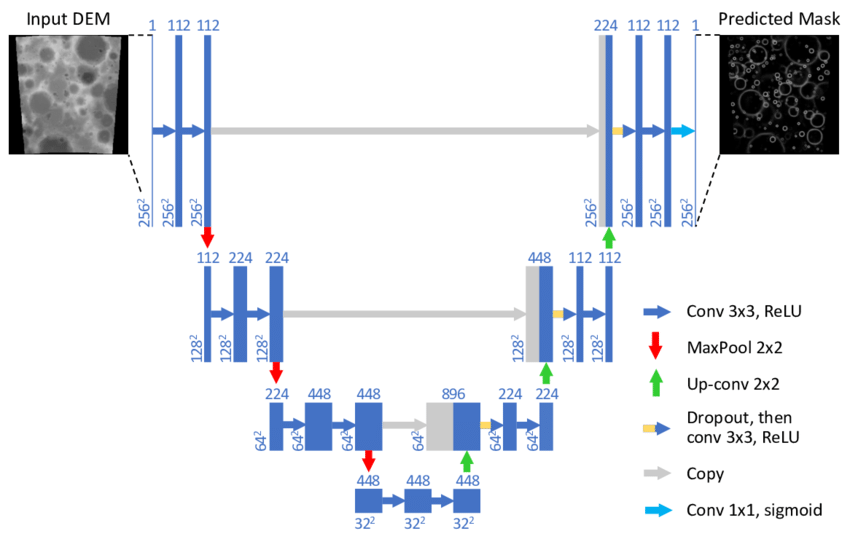

Импортируем нужные модули и зададим формат входных данных.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import Model

inputs = Input(shape=(224, 224, 3))

Для задания слоя мы создадим новый объект нужного класса и вызовем этот объект, подав ему предыдущий слой. Создадим сверточный блок для нашей сети. Паддинг укажем как «same» для того, чтобы сохранить размер изображения.

In [ ]:
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

Таким же образом создадим еще несколько сверточных блоков.

In [ ]:
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

Далее необходимо взять выход от предыдущих слоев и сконкатенировать с модулем деконволюции. Для этого используем соответствующую функцию конкатенации, подадим ей на вход деконволюционный слой и необходимый нам конволюционный слой. Повторим так необходимое число раз.

In [ ]:
up4 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up5 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

Далее соберем полученную структуру в модель фреймворка Keras.

In [ ]:
model = Model(inputs=[inputs], outputs=[conv6])

Давайте посмотрим на итоговую структуру модели и количество параметров для обучения.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_11[0][0]']              
                                )                                                           

Если вы работаете на Linux, вы можете установить graphviz и пакет pydot и визуализировать модель с помощью кода ниже. Данная операция также возможна на Windows, однако связана с достаточно длительными мученями по установке и попытке заставить это заработать, поэтому предлагаем оставить данный код в этом случае закомментированным и посмотреть на заранее сохраненное изображение данной модели ниже.  

Стоит заметить, что наша модель является уменьшенной и упрощенной копией архитектуры UNet. 

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)  # if you are on Ubuntu and can install pydot and graphviz

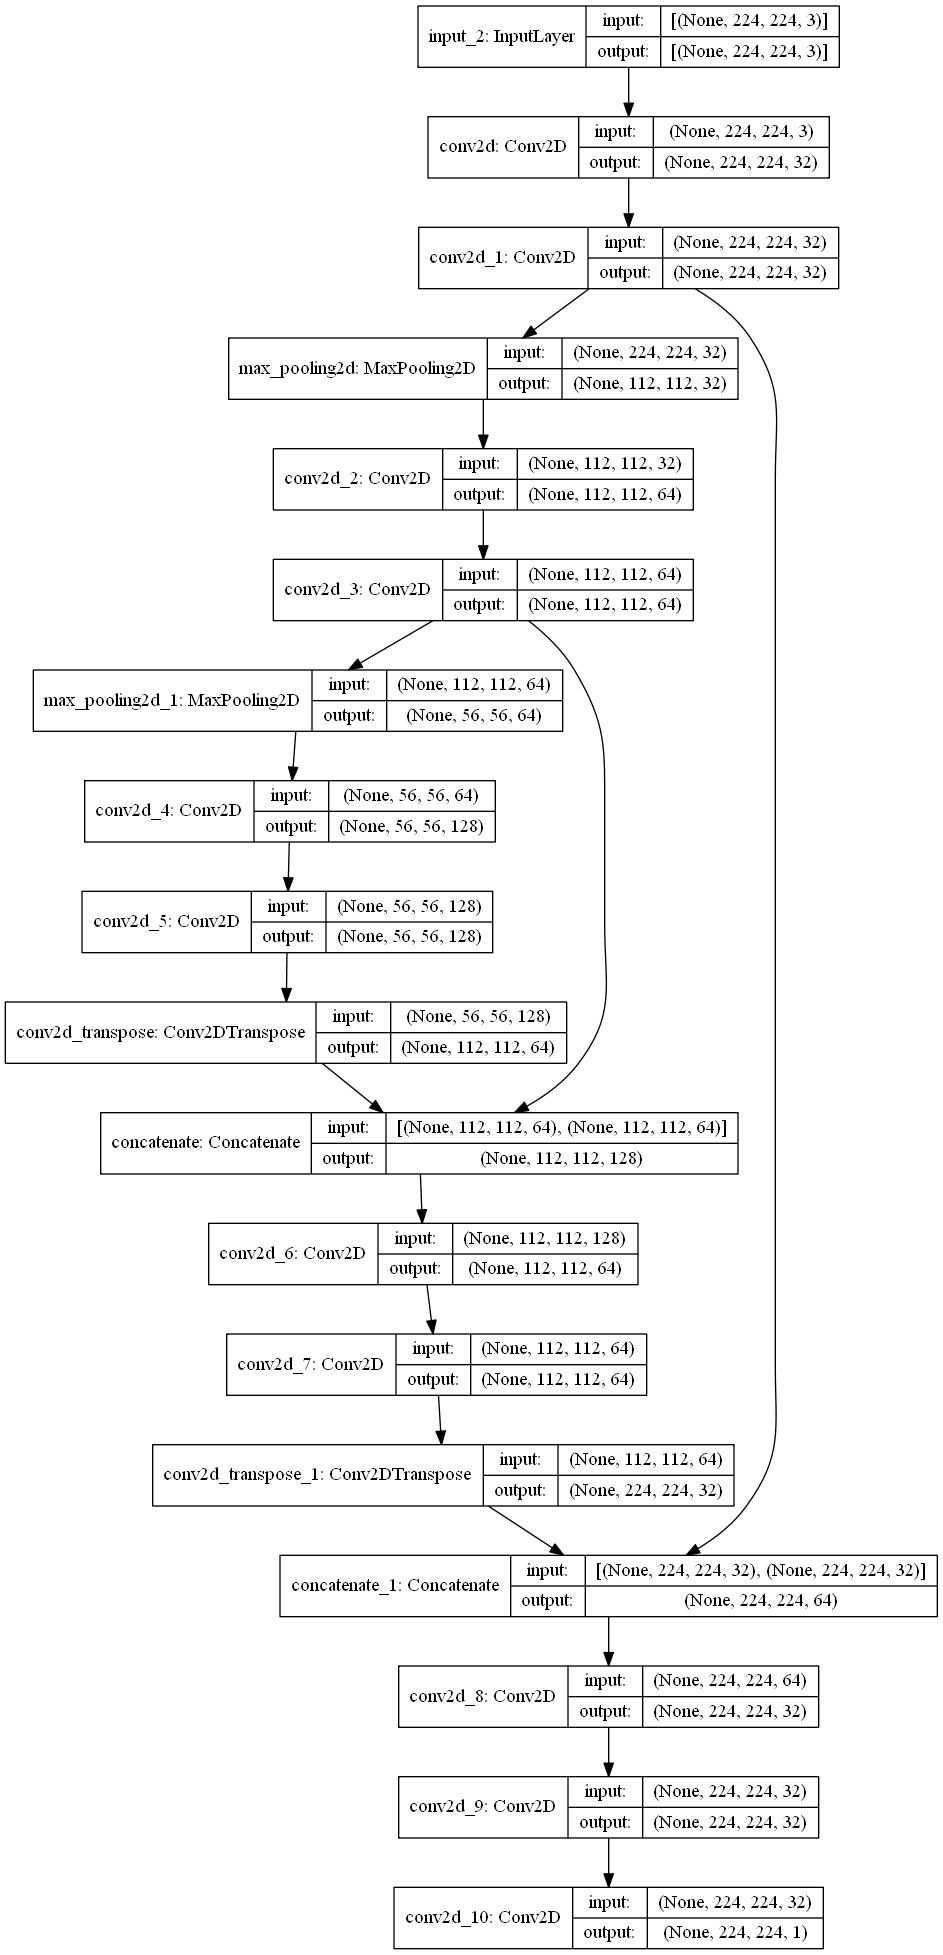

Давайте реализуем метрику (Dice coefficient), описанную в лекции, для подсчета Intersection over Union.

In [ ]:
from tensorflow.keras import backend as K

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Скомпилируем модель с созданной метрикой.

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate = 1e-3), loss=dice_coef_loss, metrics=[dice_coef])

Давайте запустим обучение нашей модели на нашем наборе данных и понаблюдаем за полученным результатом.

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
10/10 [==============================] - 1s 79ms/step - loss: -0.5722 - dice_coef: 0.5722 - val_loss: -0.5271 - val_dice_coef: 0.5271
Epoch 2/10
10/10 [==============================] - 1s 79ms/step - loss: -0.7204 - dice_coef: 0.7204 - val_loss: -0.4318 - val_dice_coef: 0.4318
Epoch 3/10
10/10 [==============================] - 1s 79ms/step - loss: -0.7113 - dice_coef: 0.7113 - val_loss: -0.6029 - val_dice_coef: 0.6029
Epoch 4/10
10/10 [==============================] - 1s 79ms/step - loss: -0.7837 - dice_coef: 0.7837 - val_loss: -0.7562 - val_dice_coef: 0.7562
Epoch 5/10
10/10 [==============================] - 1s 78ms/step - loss: -0.7482 - dice_coef: 0.7482 - val_loss: -0.5447 - val_dice_coef: 0.5447
Epoch 6/10
10/10 [==============================] - 1s 81ms/step - loss: -0.7556 - dice_coef: 0.7556 - val_loss: -0.7800 - val_dice_coef: 0.7800
Epoch 7/10
10/10 [==============================] - 1s 82ms/step - loss: -0.7689 - dice_coef: 0.7689 - val_loss: -0.8215 - val_dic

Визуализируем историю обучения с помощью фреймворка seaborn, чтобы проверить графики лосса.

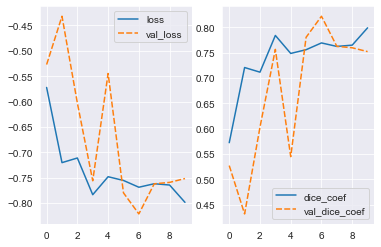

In [ ]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax = sns.lineplot(data=df[['dice_coef', 'val_dice_coef']], ax=axes[1])

Для визуальной проверки также давайте получим предсказания модели тестового набора данных ...

In [ ]:
predictions = model.predict(test_dataset)

4/4 [==============================] - 0s 14ms/step


2022-07-21 18:30:55.695309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... и визуализируем изначальное изображение, настоящую маску и предсказанную сетью маску.

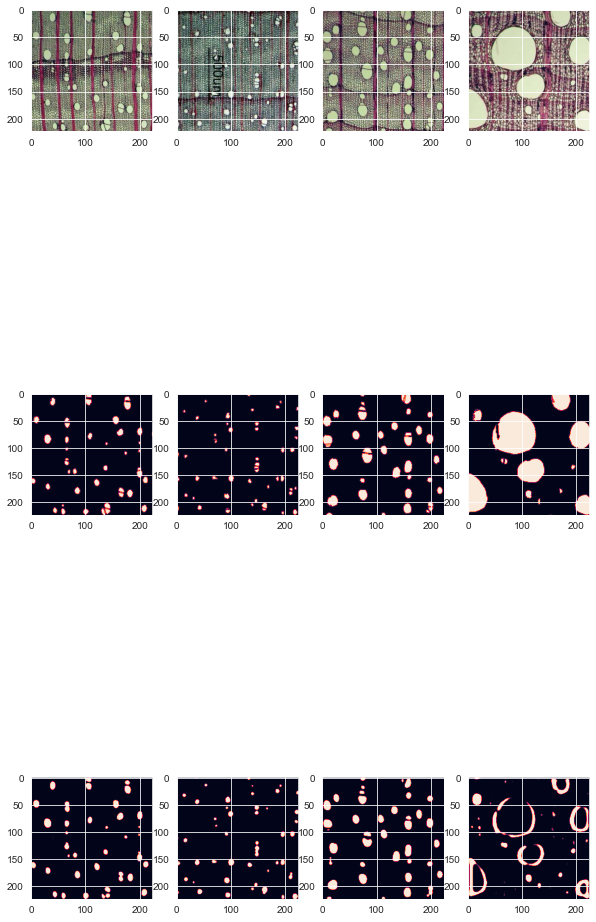

In [ ]:
f, axarr = plt.subplots(3, 4)
f.set_size_inches(10, 20)
for i in range(4):
    axarr[0, i].imshow(imgs[i])
    axarr[1, i].imshow(masks[i])
    axarr[2, i].imshow(predictions[i])